In [1]:
import warnings, torch, requests, matplotlib.pyplot as plt, networkx as nx
warnings.filterwarnings("ignore")

from transformers import BeitImageProcessor, BeitModel, BertTokenizer, BertModel
from torch_geometric.utils import to_networkx
from PIL import Image

from mmg_builder import build_multimodal_graph

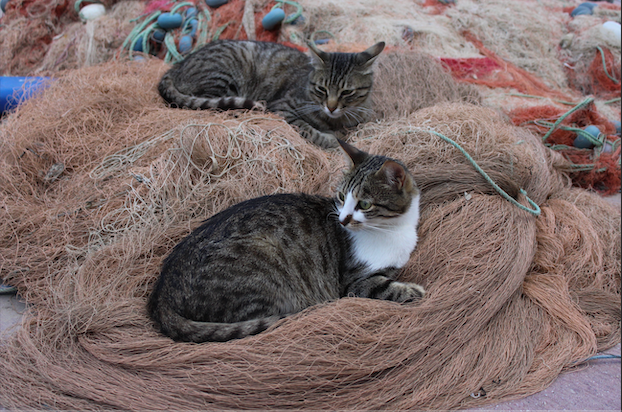

In [2]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")


model_name = "microsoft/beit-base-patch16-224"
beit_processor = BeitImageProcessor.from_pretrained(model_name)
beit = BeitModel.from_pretrained(model_name, use_safetensors=True)


# text = ["BERT is great for natural language processing!"]
text = ["BERT is great for natural language processing!", "Hi my name is Danik.", "Bob"]

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cats.png"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

image

In [3]:
text_inputs = bert_tokenizer(text, return_tensors="pt", padding=True)
print(f'{text_inputs=}')

# Forward pass (no gradient calculation needed for inference)
with torch.no_grad():
    outputs = bert(**text_inputs)

# Extract embeddings
text_embeds = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_dim]

print(f'{text_embeds.shape=}')

text_inputs={'input_ids': tensor([[  101, 14324,  2003,  2307,  2005,  3019,  2653,  6364,   999,   102],
        [  101,  7632,  2026,  2171,  2003, 19522,  2243,  1012,   102,     0],
        [  101,  3960,   102,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])}
text_embeds.shape=torch.Size([3, 10, 768])


In [4]:
img_inputs = beit_processor(images=[image]*3, return_tensors="pt")
print(f'{img_inputs["pixel_values"].shape=}')

with torch.no_grad():
    outputs = beit(**img_inputs, output_hidden_states=True)

# outputs.last_hidden_state → [batch_size, num_patches+1, hidden_dim]
# The first token is [CLS], the rest are patch embeddings
last_hidden = outputs.last_hidden_state

img_embeds = last_hidden[:, 1:, :]  # contextualized patch embeddings
print(f"Patches shape: {img_embeds.shape}")  # (1, num_patches, hidden_dim)


img_inputs["pixel_values"].shape=torch.Size([3, 3, 224, 224])
Patches shape: torch.Size([3, 196, 768])


In [5]:
res = build_multimodal_graph(
    text_embeds=text_embeds,
    image_embeds=img_embeds,
    attn_mask=text_inputs['attention_mask'],
    self_loops=False)

res

[Data(x=[212, 768], edge_index=[2, 1856]),
 Data(x=[211, 768], edge_index=[2, 1852]),
 Data(x=[205, 768], edge_index=[2, 1828])]

#### plot function

In [6]:
def visualize_mmg(data, num_img, num_text, num_quadrants=4):
    """
    Visualize multimodal graph with quadrant + text-global + fusion virtuals.
    """
    N = int(num_img ** 0.5)
    G = to_networkx(data, to_undirected=True)

    pos = {}

    # --- image grid ---
    for i in range(num_img):
        row, col = divmod(i, N)
        pos[i] = (col, -row)

    # --- text nodes ---
    offset = num_img
    for i in range(num_text):
        pos[offset + i] = (N + 2, -i)

    # --- quadrant virtuals ---
    q_nodes = list(range(num_img + num_text, num_img + num_text + num_quadrants))
    pos[q_nodes[0]] = (N/4,  1)     # top-left
    pos[q_nodes[1]] = (3*N/4, 1)    # top-right
    pos[q_nodes[2]] = (N/4, -N-1)   # bottom-left
    pos[q_nodes[3]] = (3*N/4, -N-1) # bottom-right

    # --- text-global ---
    tg = num_img + num_text + num_quadrants
    pos[tg] = (N + 4, -num_text/2)

    # --- fusion virtual ---
    fusion = tg + 1
    pos[fusion] = (N/2, 2)

    # --- node colors ---
    colors = []
    for n in G.nodes():
        if n < num_img:
            colors.append("skyblue")  # image
        elif n < num_img + num_text:
            colors.append("lightgreen")  # text
        elif n in q_nodes:
            colors.append("orange")  # quadrants
        elif n == tg:
            colors.append("red")  # text-global
        elif n == fusion:
            colors.append("purple")  # fusion
        else:
            colors.append("gray")  # fallback

    # --- plot ---
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos,
            node_color=colors,
            with_labels=False,
            node_size=200,
            edge_color="gray",
            alpha=0.7)
    plt.title("Multimodal Graph with Hierarchical Virtual Nodes", fontsize=12)
    plt.show()


### plot

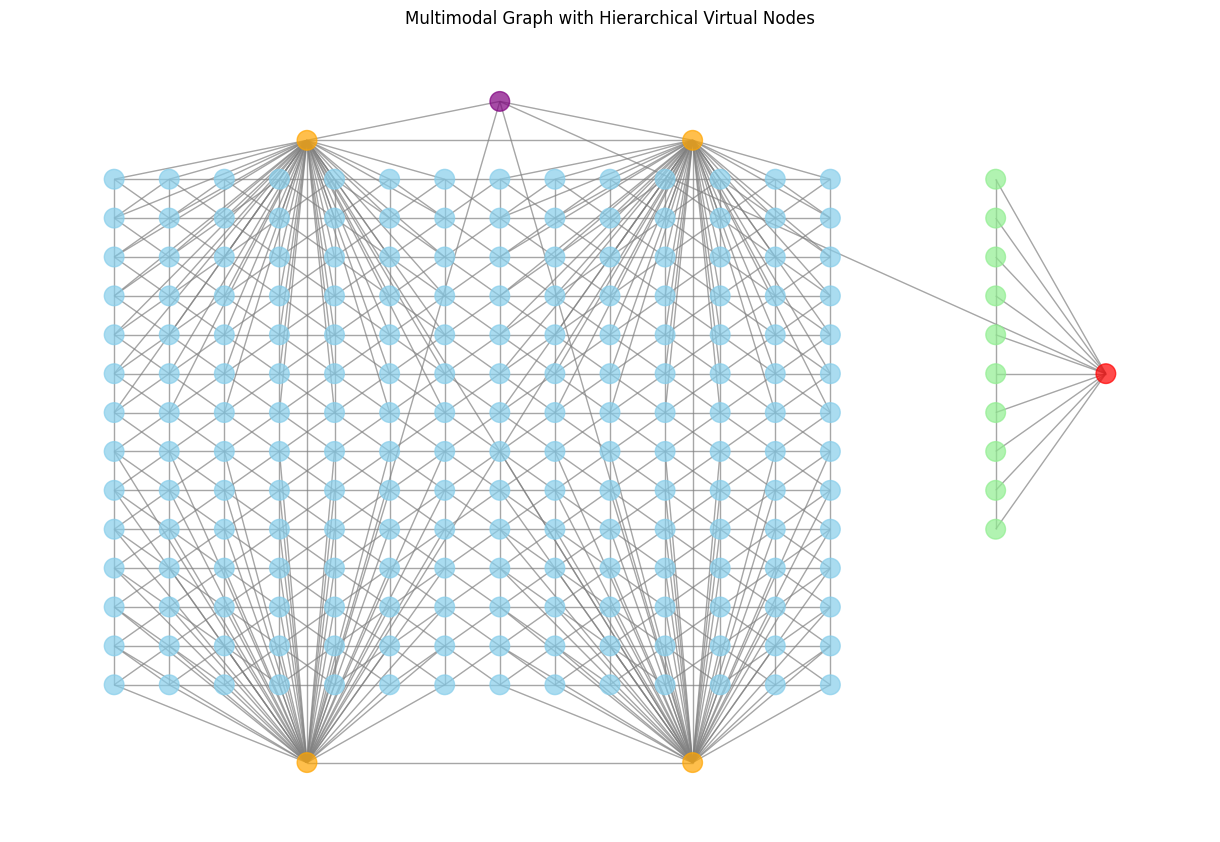

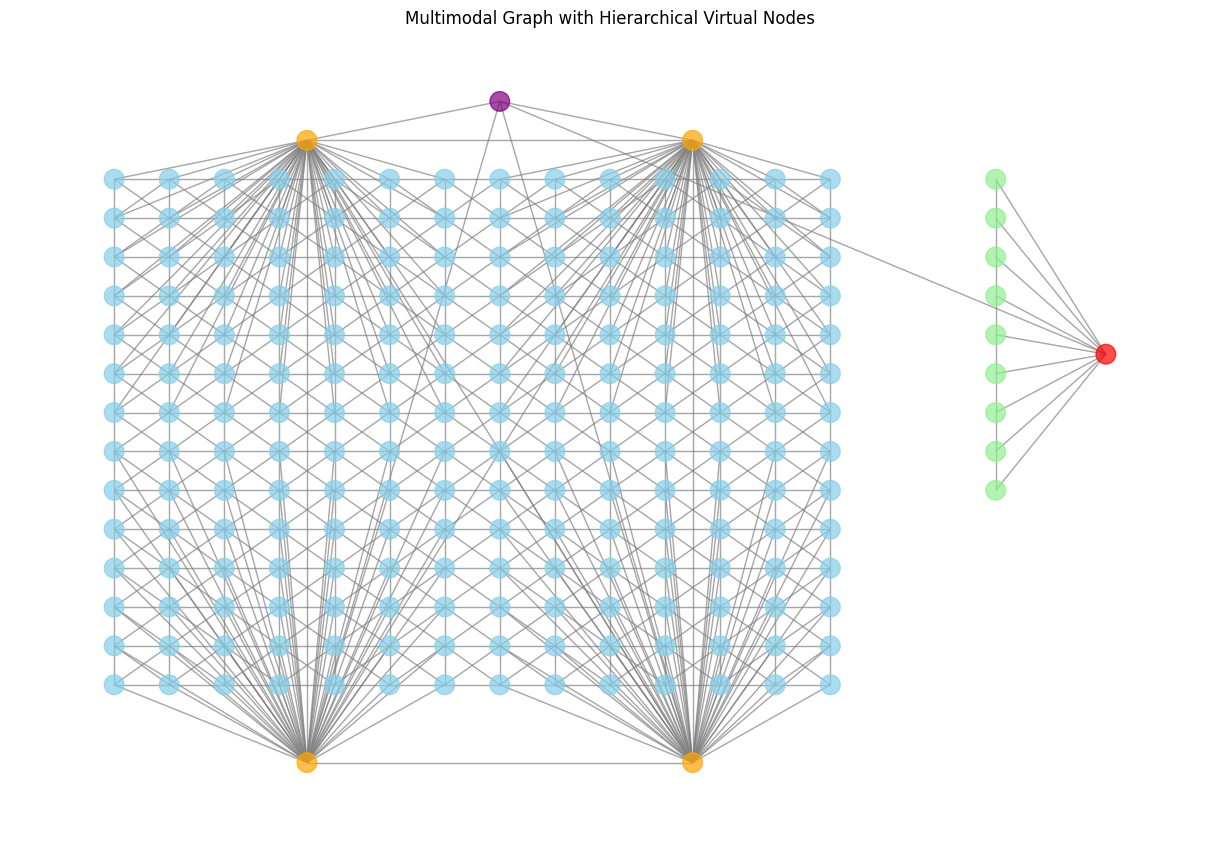

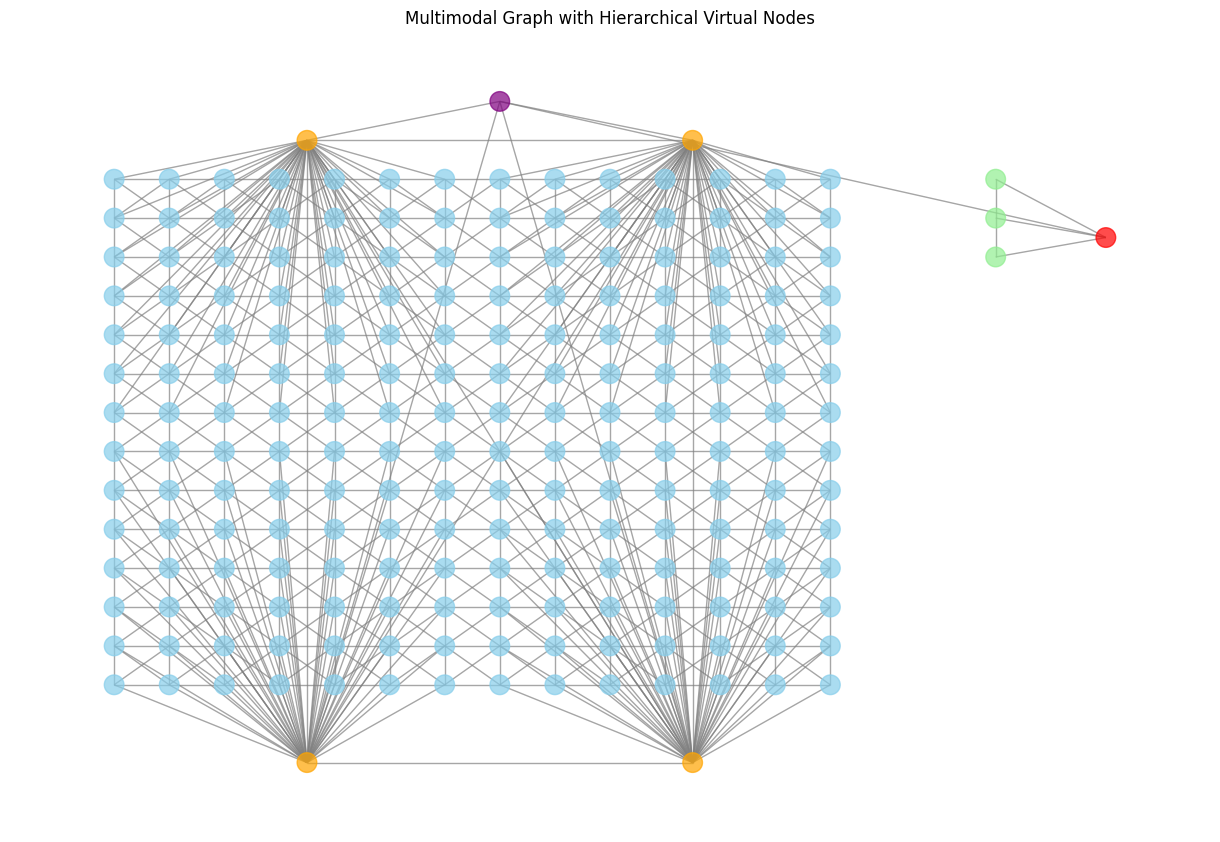

In [7]:
for i in range(len(res)):
	visualize_mmg(res[i], num_img=img_embeds.shape[1], num_text=(text_inputs['attention_mask'][i] == 1).sum().item())